In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import shap
from config import FEATURES
from model import (pca, xgb_grid_search, lgbm_grid_search, elasticnet_grid_search)
import data_utils as dat
import eda_utils as eda
import model_utils as md

Read in data

In [38]:
flnm = 'F:\\GitHub\\Kaggle\\RainFall\\data\\train.csv'
df = pd.read_csv(flnm)

In [3]:
eda.summary_table(df)

rainfall                  0            1
cloud     count  540.000000  1650.000000
          mean    55.522222    82.332727
          std     19.982494    11.113242
          min      2.000000    20.000000
          25%     43.000000    80.000000
...                     ...          ...
windspeed min      4.400000     4.500000
          25%     12.300000    14.600000
          50%     16.900000    21.600000
          75%     25.100000    28.400000
          max     59.500000    59.500000

[96 rows x 2 columns]

In [4]:
X, y=dat.prepare_model_data(df, FEATURES, n_lags=5)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [5]:
eda.basic_summary(X_scaled)

{'shape': (2185, 80),
 'columns': ['pressure_lag1',
  'pressure_lag2',
  'pressure_lag3',
  'pressure_lag4',
  'pressure_lag5',
  'maxtemp_lag1',
  'maxtemp_lag2',
  'maxtemp_lag3',
  'maxtemp_lag4',
  'maxtemp_lag5',
  'temparature_lag1',
  'temparature_lag2',
  'temparature_lag3',
  'temparature_lag4',
  'temparature_lag5',
  'mintemp_lag1',
  'mintemp_lag2',
  'mintemp_lag3',
  'mintemp_lag4',
  'mintemp_lag5',
  'dewpoint_lag1',
  'dewpoint_lag2',
  'dewpoint_lag3',
  'dewpoint_lag4',
  'dewpoint_lag5',
  'humidity_lag1',
  'humidity_lag2',
  'humidity_lag3',
  'humidity_lag4',
  'humidity_lag5',
  'cloud_lag1',
  'cloud_lag2',
  'cloud_lag3',
  'cloud_lag4',
  'cloud_lag5',
  'sunshine_lag1',
  'sunshine_lag2',
  'sunshine_lag3',
  'sunshine_lag4',
  'sunshine_lag5',
  'winddirection_lag1',
  'winddirection_lag2',
  'winddirection_lag3',
  'winddirection_lag4',
  'winddirection_lag5',
  'windspeed_lag1',
  'windspeed_lag2',
  'windspeed_lag3',
  'windspeed_lag4',
  'windspeed_lag5

In [6]:
X_scaled.var().sort_values().head()

cloud_lag1       1.000458
humidity_lag5    1.000458
humidity_lag4    1.000458
cloud_ma4        1.000458
humidity_lag2    1.000458
dtype: float64

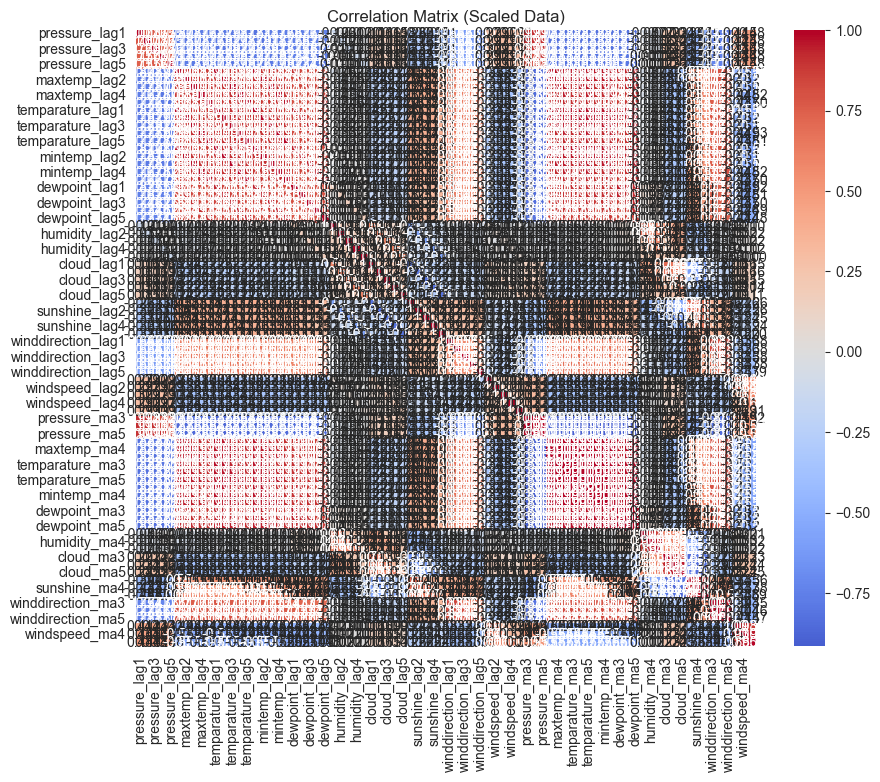

In [7]:
# Compute the correlation matrix
corr = X_scaled.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size to fit your number of variables
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title("Correlation Matrix (Scaled Data)")
plt.show()

In [8]:
X_scaled.columns

Index(['pressure_lag1', 'pressure_lag2', 'pressure_lag3', 'pressure_lag4',
       'pressure_lag5', 'maxtemp_lag1', 'maxtemp_lag2', 'maxtemp_lag3',
       'maxtemp_lag4', 'maxtemp_lag5', 'temparature_lag1', 'temparature_lag2',
       'temparature_lag3', 'temparature_lag4', 'temparature_lag5',
       'mintemp_lag1', 'mintemp_lag2', 'mintemp_lag3', 'mintemp_lag4',
       'mintemp_lag5', 'dewpoint_lag1', 'dewpoint_lag2', 'dewpoint_lag3',
       'dewpoint_lag4', 'dewpoint_lag5', 'humidity_lag1', 'humidity_lag2',
       'humidity_lag3', 'humidity_lag4', 'humidity_lag5', 'cloud_lag1',
       'cloud_lag2', 'cloud_lag3', 'cloud_lag4', 'cloud_lag5', 'sunshine_lag1',
       'sunshine_lag2', 'sunshine_lag3', 'sunshine_lag4', 'sunshine_lag5',
       'winddirection_lag1', 'winddirection_lag2', 'winddirection_lag3',
       'winddirection_lag4', 'winddirection_lag5', 'windspeed_lag1',
       'windspeed_lag2', 'windspeed_lag3', 'windspeed_lag4', 'windspeed_lag5',
       'pressure_ma3', 'pressure_ma4', 

In [9]:
X_pca, pca = pca(X_scaled)

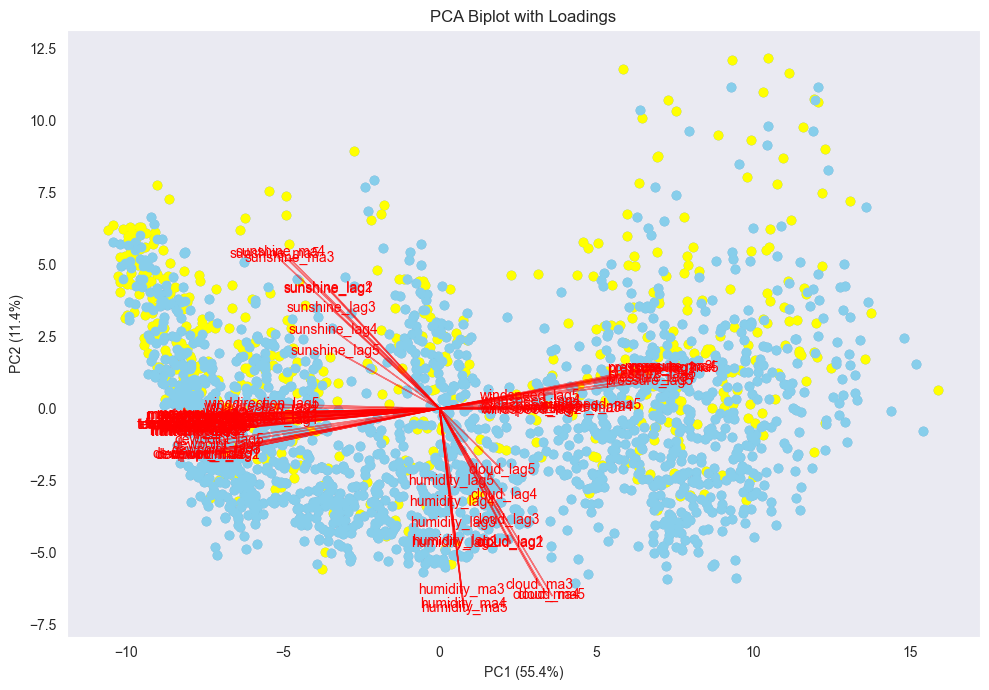

In [10]:
# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df["Rain"] = y.values
# Plot PCA biplot
plt.figure(figsize=(10, 7))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6)
colors = ['yellow', 'skyblue']
labels = ['No Rain', 'Rain']

for i, label in enumerate([0, 1]):
    subset = pca_df[pca_df["Rain"] == label]
    plt.scatter(subset["PC1"], subset["PC2"],
                c=colors[i], label=labels[i], alpha=1)
# Add loadings (feature contributions)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(X.columns):
    plt.arrow(0, 0, loadings[i, 0]*8, loadings[i, 1]*8,
              color='red', alpha=0.5, head_width=0.02)
    plt.text(loadings[i, 0]*8, loadings[i, 1]*8, feature,
             color='red', ha='center', va='center')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA Biplot with Loadings')
plt.grid()
plt.tight_layout()
plt.show()

☀️ Sunshine → 💨 Evaporation → ☁️ Clouds → 💧 Humidity + rising air → 🌧️ Rain

🌀 Low Pressure + High Humidity + Wind Lifting Air = Rain Party
🔆 High Pressure + Low Humidity = Sunny Dry Days

In [11]:
def create_physics_features(df):
    df = df.copy()

    df['sun_evap_effect'] = df['sunshine_ma3'] * df['humidity_ma3']
    df['cloud_building'] = df['sunshine_ma3'] * df['cloud_ma3']
    df['rain_chain'] = df['sunshine_ma3'] * df['humidity_ma3'] * df['cloud_ma3']

    df['rain_party'] = -df['pressure_ma3'] * df['humidity_ma3'] * df['windspeed_ma3']
    df['dry_day_score'] = df['pressure_ma3'] * (1 - df['humidity_ma3'])

    return df
X_scaled = create_physics_features(X_scaled)

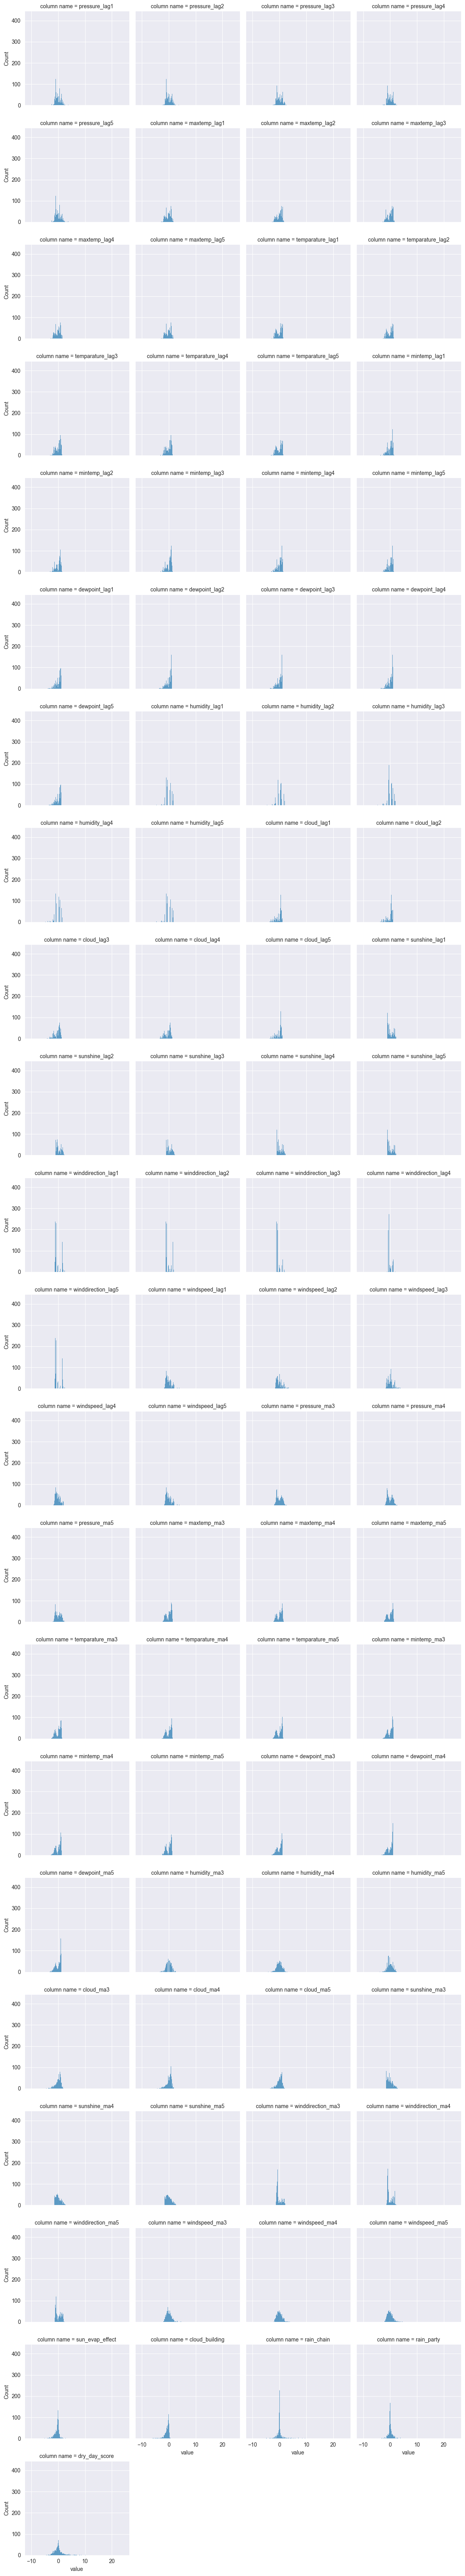

In [12]:
sns.displot(
    data=X_scaled.melt(var_name='column name'),
    x='value',
    col='column name',
    height=3,
    kind='hist',
    col_wrap=4  # change this number based on how many plots per row you want
)
#plt.show()

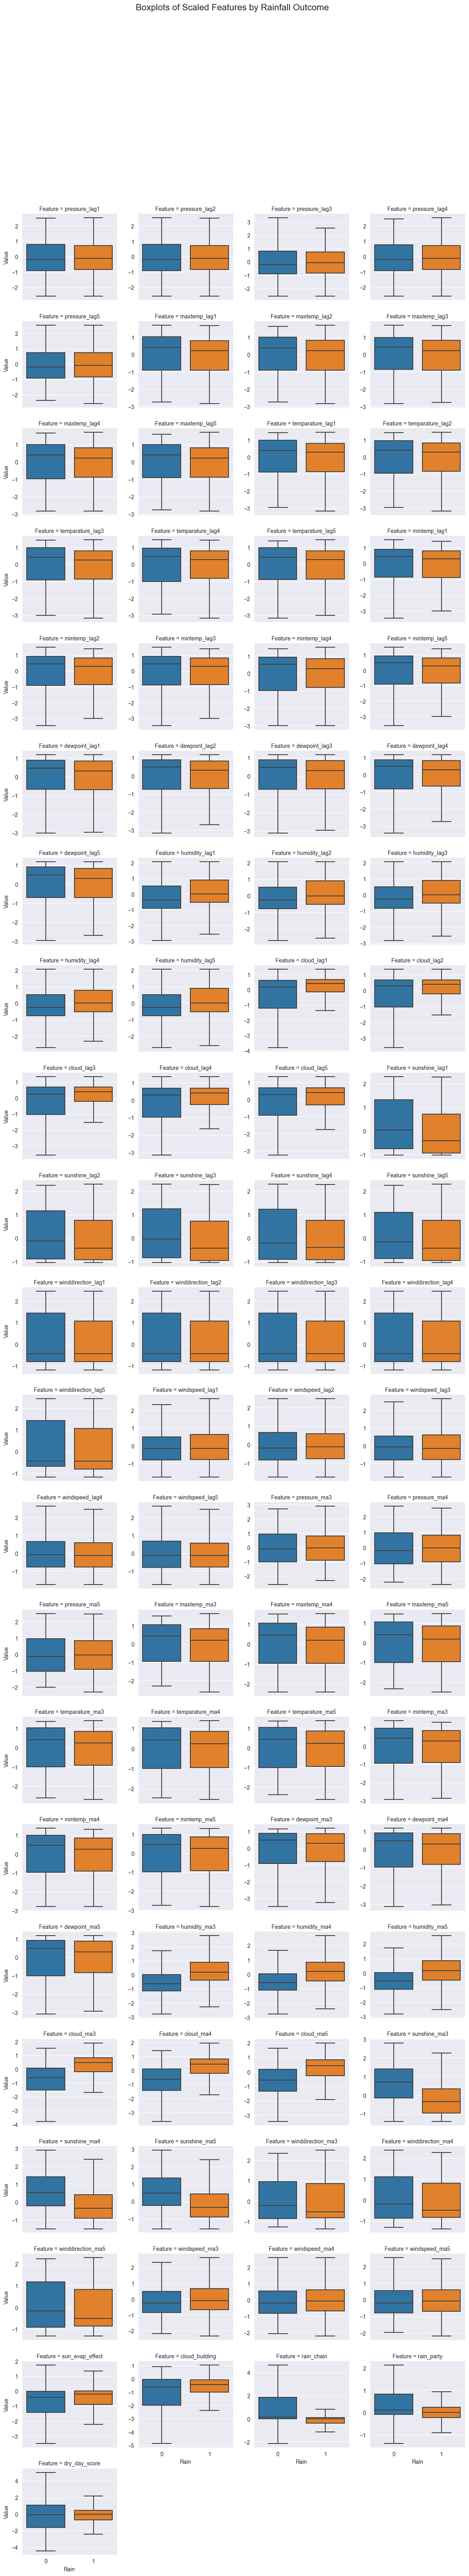

In [13]:
# Merge X and y to one dataframe for plotting
X_plot = X_scaled.copy()
X_plot['Rain'] = y.reset_index(drop=True)  # ensure index aligns

# Melt to long format for facet boxplots
df_long = X_plot.melt(id_vars='Rain', var_name='Feature', value_name='Value')

# Plot
g = sns.catplot(
    data=df_long,
    x='Rain', y='Value',
    col='Feature',
    kind='box',
    col_wrap=4,
    height=3,
    sharey=False,
    showfliers=False  # optional: hide outliers for cleaner plots
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Boxplots of Scaled Features by Rainfall Outcome", fontsize=16)
plt.show()


In [14]:
# Keep upper triangle only
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find features with correlation > 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)
# Drop them
X_reduced = X_scaled.drop(columns=to_drop)

['temparature_lag1', 'temparature_lag2', 'temparature_lag3', 'temparature_lag4', 'temparature_lag5', 'mintemp_lag1', 'mintemp_lag2', 'mintemp_lag3', 'mintemp_lag4', 'mintemp_lag5', 'dewpoint_lag1', 'dewpoint_lag2', 'dewpoint_lag3', 'dewpoint_lag4', 'dewpoint_lag5', 'pressure_ma3', 'pressure_ma4', 'pressure_ma5', 'maxtemp_ma3', 'maxtemp_ma4', 'maxtemp_ma5', 'temparature_ma3', 'temparature_ma4', 'temparature_ma5', 'mintemp_ma3', 'mintemp_ma4', 'mintemp_ma5', 'dewpoint_ma3', 'dewpoint_ma4', 'dewpoint_ma5', 'humidity_ma4', 'humidity_ma5', 'cloud_ma4', 'cloud_ma5', 'sunshine_ma4', 'sunshine_ma5', 'winddirection_ma4', 'winddirection_ma5', 'windspeed_ma4', 'windspeed_ma5']


In [15]:
X_reduced.columns

Index(['pressure_lag1', 'pressure_lag2', 'pressure_lag3', 'pressure_lag4',
       'pressure_lag5', 'maxtemp_lag1', 'maxtemp_lag2', 'maxtemp_lag3',
       'maxtemp_lag4', 'maxtemp_lag5', 'humidity_lag1', 'humidity_lag2',
       'humidity_lag3', 'humidity_lag4', 'humidity_lag5', 'cloud_lag1',
       'cloud_lag2', 'cloud_lag3', 'cloud_lag4', 'cloud_lag5', 'sunshine_lag1',
       'sunshine_lag2', 'sunshine_lag3', 'sunshine_lag4', 'sunshine_lag5',
       'winddirection_lag1', 'winddirection_lag2', 'winddirection_lag3',
       'winddirection_lag4', 'winddirection_lag5', 'windspeed_lag1',
       'windspeed_lag2', 'windspeed_lag3', 'windspeed_lag4', 'windspeed_lag5',
       'humidity_ma3', 'cloud_ma3', 'sunshine_ma3', 'winddirection_ma3',
       'windspeed_ma3', 'sun_evap_effect', 'cloud_building', 'rain_chain',
       'rain_party', 'dry_day_score'],
      dtype='object')

In [16]:
y.value_counts()

1    1646
0     539
Name: rainfall, dtype: int64

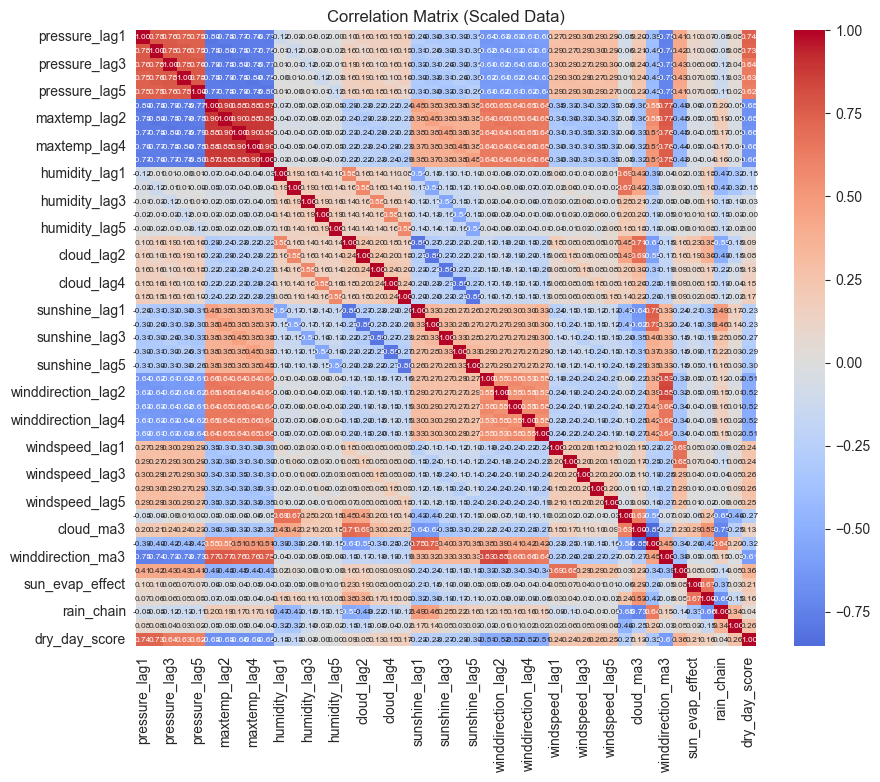

In [17]:
# Compute the correlation matrix
corr = X_reduced.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size to fit your number of variables
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", center=0, annot_kws={"size": 6},)
plt.title("Correlation Matrix (Scaled Data)")
plt.show()

In [18]:
# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(
    X_reduced, y, stratify=y, test_size=0.2, random_state=42
)

Model

In [19]:
best_xgb_model, best_xgb_params, best_xgb_score = xgb_grid_search(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [20]:
best_xgb_score

0.852322764765817

In [21]:
best_xgb_params

{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 5,
 'subsample': 0.8}

In [22]:
feature_names = X_train.columns.str.strip().str.lower().tolist()
print(feature_names)

['pressure_lag1', 'pressure_lag2', 'pressure_lag3', 'pressure_lag4', 'pressure_lag5', 'maxtemp_lag1', 'maxtemp_lag2', 'maxtemp_lag3', 'maxtemp_lag4', 'maxtemp_lag5', 'humidity_lag1', 'humidity_lag2', 'humidity_lag3', 'humidity_lag4', 'humidity_lag5', 'cloud_lag1', 'cloud_lag2', 'cloud_lag3', 'cloud_lag4', 'cloud_lag5', 'sunshine_lag1', 'sunshine_lag2', 'sunshine_lag3', 'sunshine_lag4', 'sunshine_lag5', 'winddirection_lag1', 'winddirection_lag2', 'winddirection_lag3', 'winddirection_lag4', 'winddirection_lag5', 'windspeed_lag1', 'windspeed_lag2', 'windspeed_lag3', 'windspeed_lag4', 'windspeed_lag5', 'humidity_ma3', 'cloud_ma3', 'sunshine_ma3', 'winddirection_ma3', 'windspeed_ma3', 'sun_evap_effect', 'cloud_building', 'rain_chain', 'rain_party', 'dry_day_score']


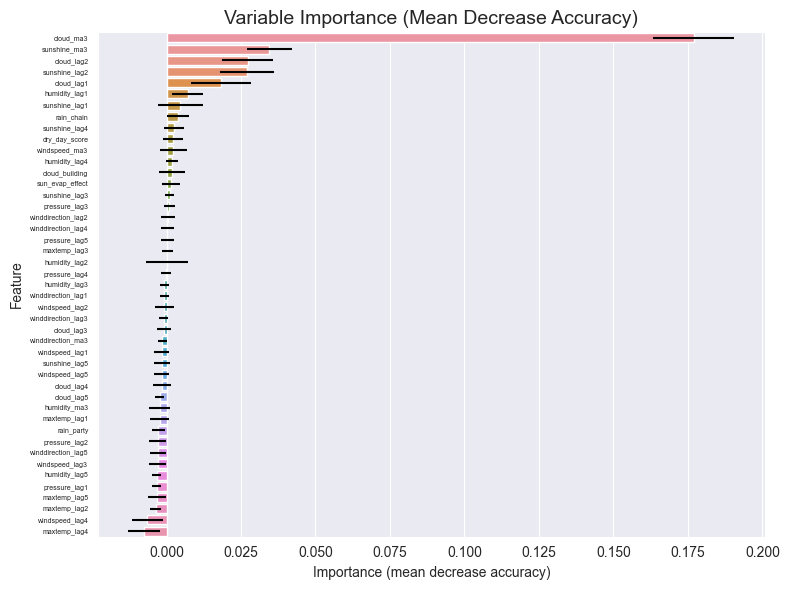

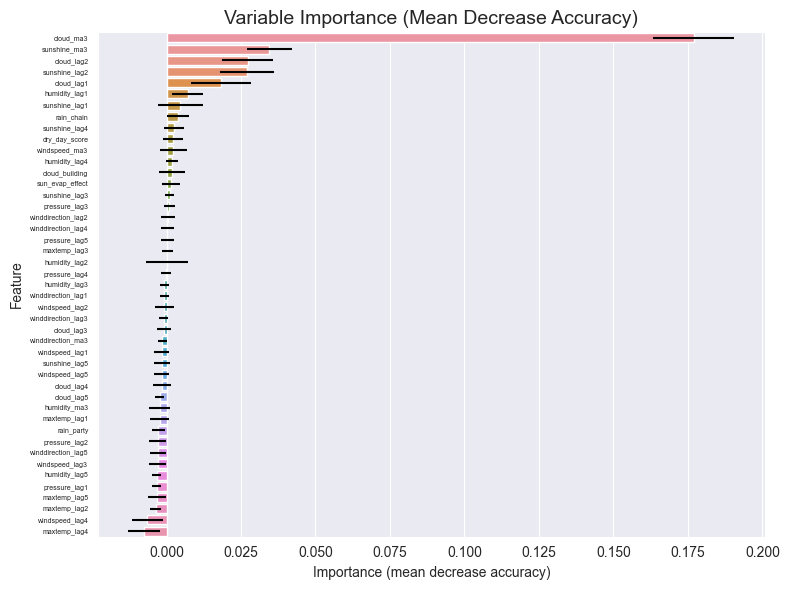

In [23]:
mda = md.compute_mda_importance(best_xgb_model, X_val, y_val, feature_names)
md.plot_mda_importance(mda)

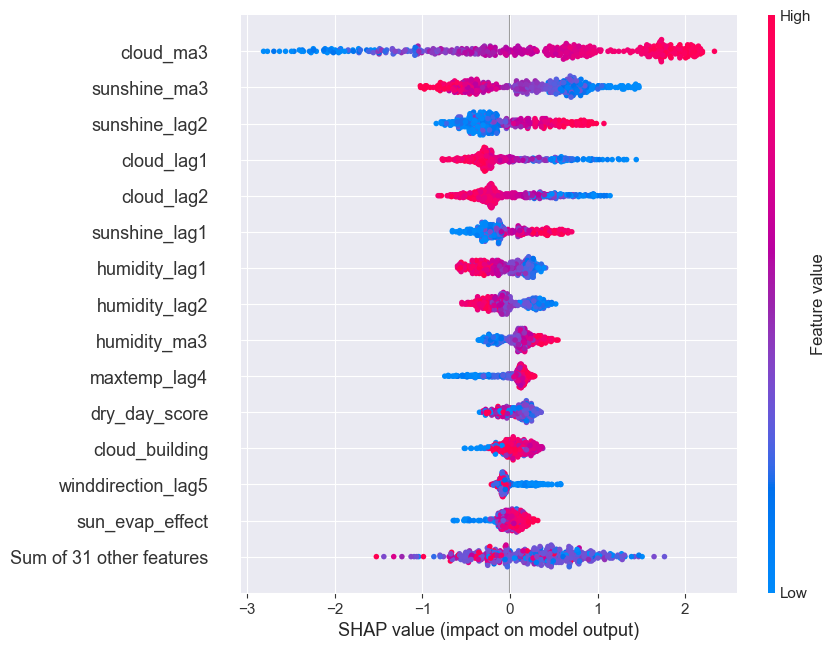

Text(0.5, 1.0, 'XGBoost SHAP')

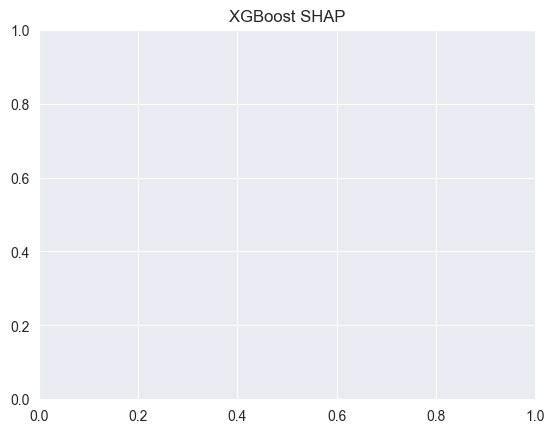

In [24]:
explainer_xgb = shap.Explainer(best_xgb_model)
shap_values_xgb = explainer_xgb(X_val)
shap.plots.beeswarm(shap_values_xgb, max_display=15)
plt.title("XGBoost SHAP")

In [25]:
best_lgbm_model, best_lgbm_params, best_lgbm_score = lgbm_grid_search(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Info] Number of posit

C:\Users\Ye Chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
'list' object has no attribute 'read'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Ye Chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Ye Chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\run\__init__.py", line 145, in __new__
    process = cls.create_process(command, stdin, cwd=cwd, env=env, shell=shell)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ye Chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\run\__i

In [26]:
best_lgbm_params

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 3,
 'subsample': 0.8}

In [27]:
best_lgbm_score

0.8487737163705272

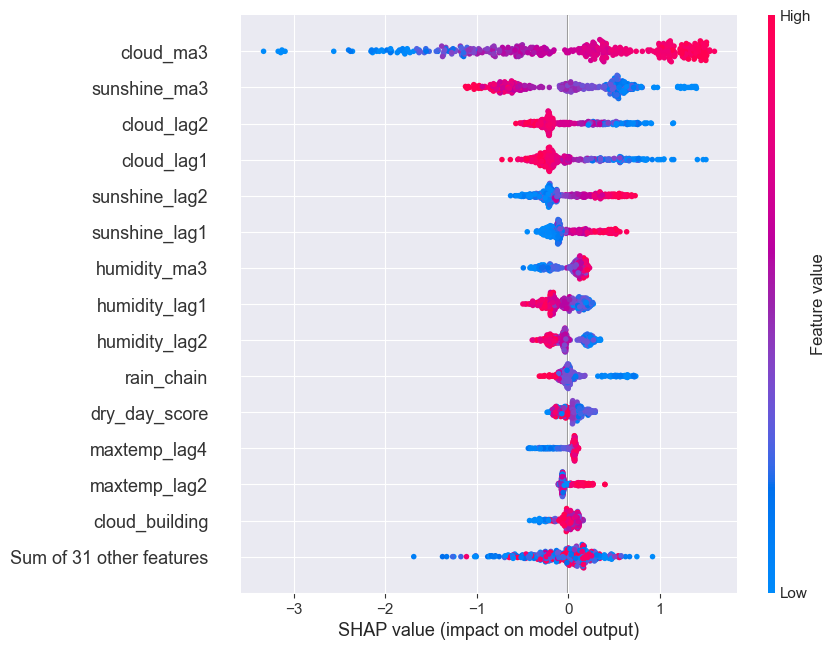

Text(0.5, 1.0, 'LightGBM SHAP')

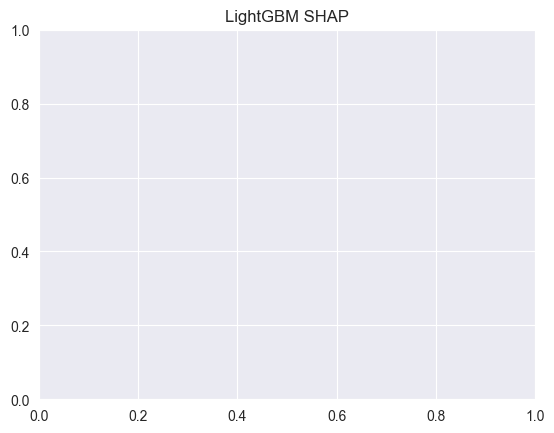

In [28]:
explainer_lgb = shap.Explainer(best_lgbm_model)
shap_values_lgb = explainer_lgb(X_val)
shap.plots.beeswarm(shap_values_lgb, max_display=15)
plt.title("LightGBM SHAP")

In [29]:
best_enet_model, best_enet_params, best_enet_pscore = elasticnet_grid_search(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [30]:
best_enet_pscore

0.8852433053742849

In [31]:
print(best_enet_model)
print(best_enet_pscore)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.1, l1_ratio=0.5, max_iter=5000,
                                    penalty='elasticnet', solver='saga'))])
0.8852433053742849


In [32]:
print(best_enet_model.named_steps.keys())

dict_keys(['scaler', 'clf'])


In [33]:
# Extract coefficients (the last step of the pipeline)
logreg_model = best_enet_model.named_steps['clf']
coef = pd.Series(logreg_model.coef_[0], index=X_train.columns)
selected_features = coef[coef != 0].index.tolist()

print("Selected features:", selected_features)

Selected features: ['pressure_lag2', 'maxtemp_lag4', 'maxtemp_lag5', 'humidity_lag1', 'humidity_lag2', 'humidity_lag4', 'humidity_lag5', 'cloud_lag1', 'cloud_lag2', 'cloud_lag3', 'sunshine_lag1', 'sunshine_lag2', 'sunshine_lag4', 'sunshine_lag5', 'winddirection_lag5', 'windspeed_lag2', 'windspeed_lag3', 'windspeed_lag4', 'windspeed_lag5', 'humidity_ma3', 'cloud_ma3', 'sunshine_ma3', 'windspeed_ma3', 'cloud_building', 'dry_day_score']


In [34]:
# Get non-zero coefficients
non_zero_coef = coef[coef != 0]

# Print as a sorted table
print("Selected features and their effect sizes:\n")
print(non_zero_coef.sort_values(ascending=False).to_frame(name='Effect Size'))

Selected features and their effect sizes:

                    Effect Size
cloud_ma3              1.951407
sunshine_lag2          0.718824
humidity_ma3           0.697132
sunshine_lag1          0.446366
maxtemp_lag4           0.348022
cloud_lag3             0.135015
windspeed_ma3          0.091362
maxtemp_lag5           0.050519
sunshine_lag4          0.050246
dry_day_score          0.027723
humidity_lag4          0.009066
windspeed_lag3         0.001501
sunshine_lag5         -0.007938
windspeed_lag4        -0.009671
cloud_building        -0.020396
windspeed_lag2        -0.027094
humidity_lag5         -0.059449
windspeed_lag5        -0.069456
pressure_lag2         -0.073447
winddirection_lag5    -0.078125
humidity_lag2         -0.291254
humidity_lag1         -0.338559
cloud_lag2            -0.741518
cloud_lag1            -0.805359
sunshine_ma3          -1.107868


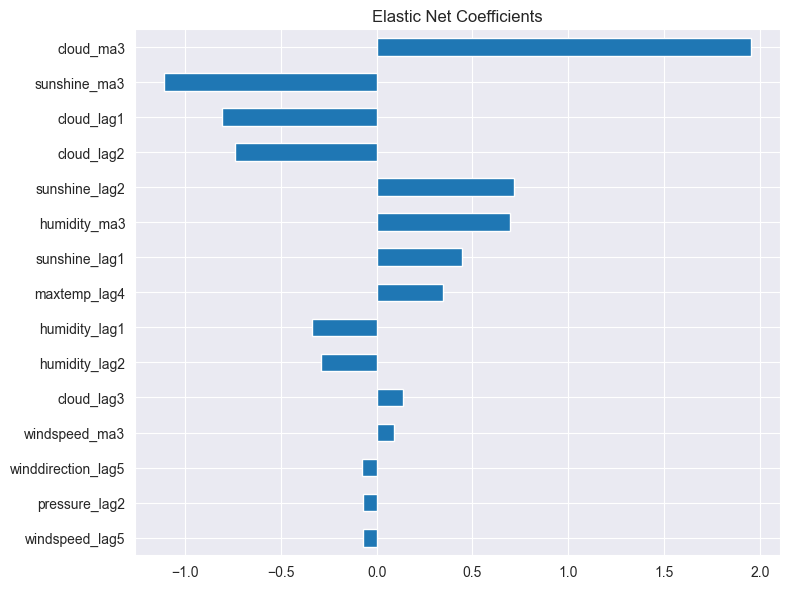

In [35]:
# SHAP for Elastic Net (coefficients as proxy)
enet_shap = pd.Series(logreg_model.coef_.ravel(), index=X_train.columns).sort_values(key=abs, ascending=False)
# Elastic Net: bar plot of coefficients
enet_shap[:15].plot(kind='barh', title="Elastic Net Coefficients", figsize=(8,6))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Model diagnostics


== ElasticNet ==


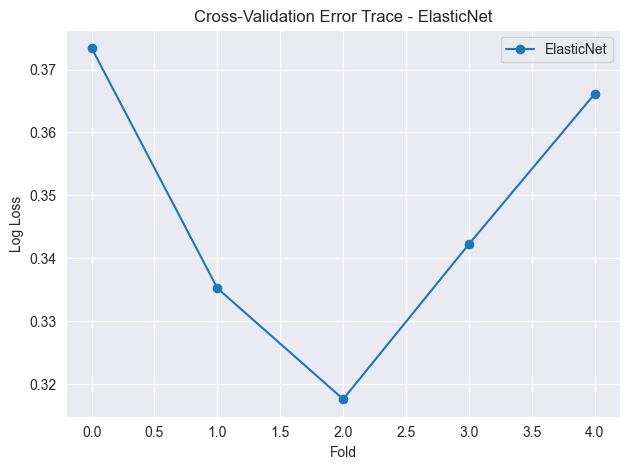

Mean log loss: 0.3470 ± 0.0204


C:\Users\Ye Chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Ye Chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Ye Chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Ye Chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Ye Chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  

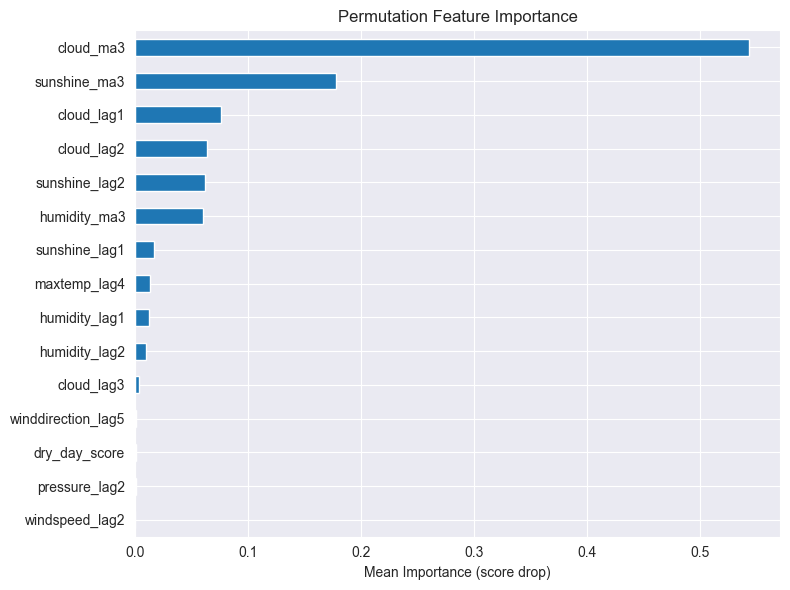


== XGBoost ==


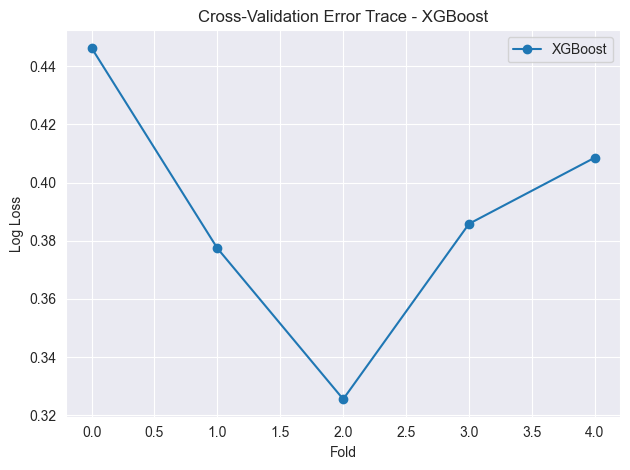

Mean log loss: 0.3887 ± 0.0396


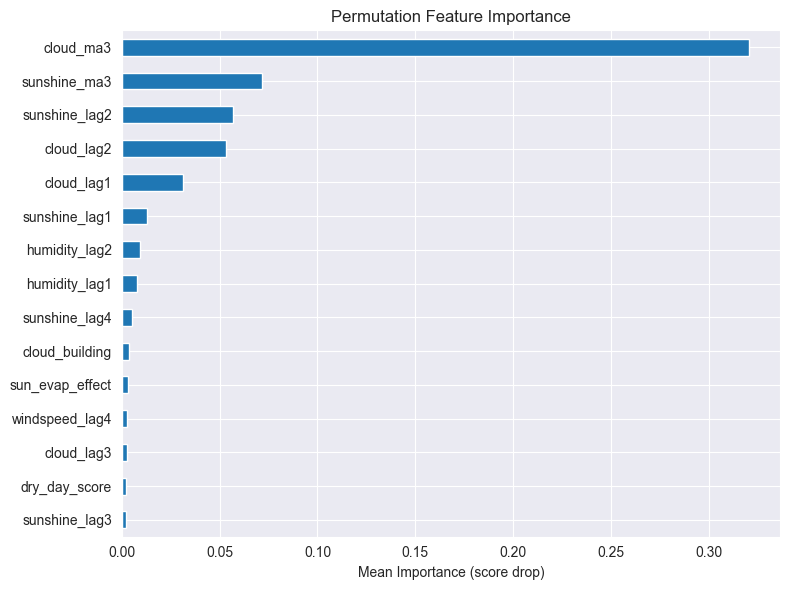


== LightGBM ==
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Info] Number of positive: 1316, number of negative: 432
[LightGBM]

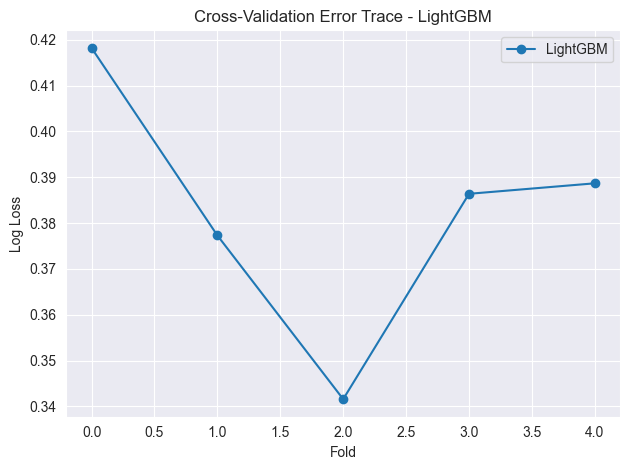

Mean log loss: 0.3824 ± 0.0246
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samp

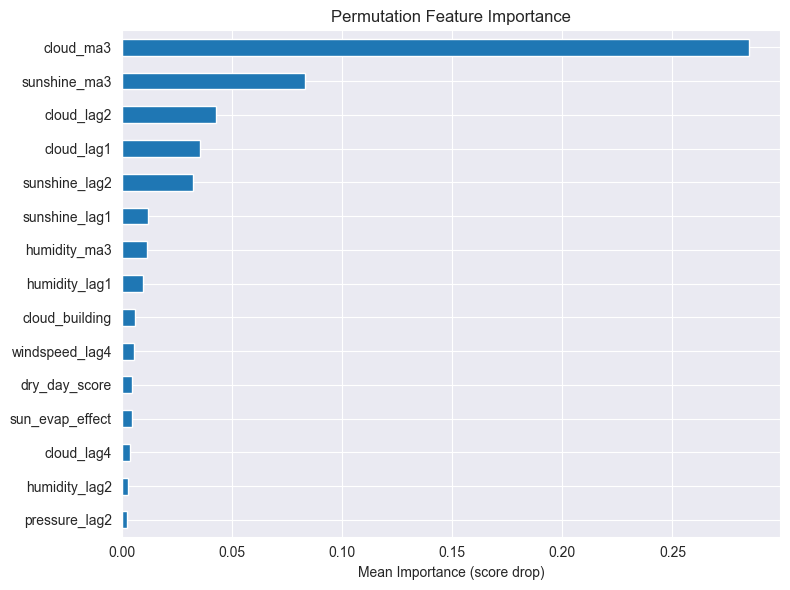

In [36]:
models = {
    "ElasticNet": logreg_model,
    "XGBoost": best_xgb_model,
    "LightGBM": best_lgbm_model
}

for name, model in models.items():
    print(f"\n== {name} ==")
    md.run_cv_error_trace(model, X_reduced, y, model_name=name)
    md.run_permutation_test(model, X_val, y_val)